## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd
from scipy import stats

from grr.cell_class import Cell
from grr.Trace import detectSpikes
from grr.Tools import stripNan
from ezephys.pltools import hide_border

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fI')

## Load data

First we'll just load the current step data.

In [4]:
DATA_PATH = os.path.join('data', 'raw', '5HT', 'current_steps')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
fnames

,Cell,R,C,hold,Steps
0,DRN159,707,43,-11.0,17n23013.abf
1,DRN160,365,79,-9.8,17n23017.abf
2,DRN162,485,57,-17.1,17n23022.abf
3,DRN163,1400,61,2.4,17n23027.abf
4,DRN164,919,39,-27.0,17n23034.abf
5,DRN165,759,63,-14.6,17n23038.abf
6,DRN196,923,74,-6.0,18111055.abf
7,DRN316,1200,40,-8.5,18420001.abf
8,DRN317,743,93,3.7,18420006.abf
9,DRN318,702,51,-8.0,18420025.abf


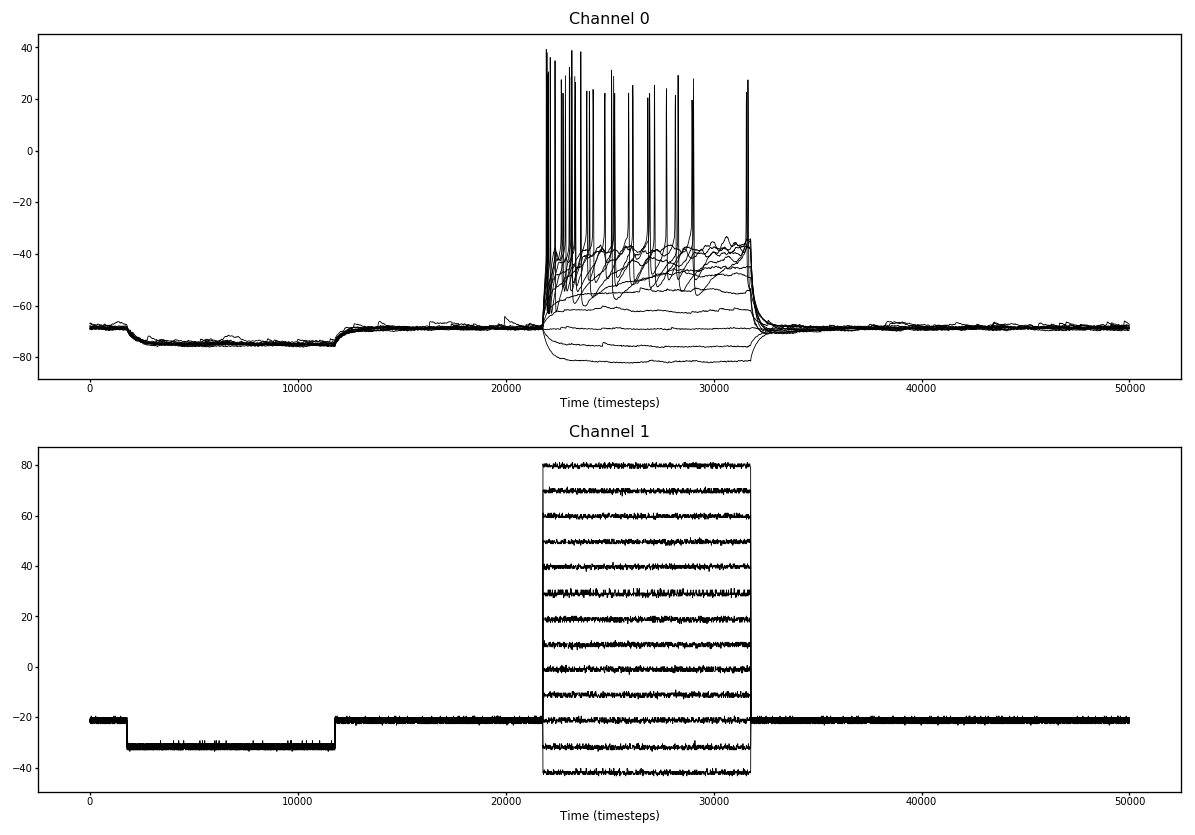

In [5]:
curr_steps = Cell().read_ABF([os.path.join(DATA_PATH, fn) for fn in fnames['Steps']])
curr_steps[0].plot()

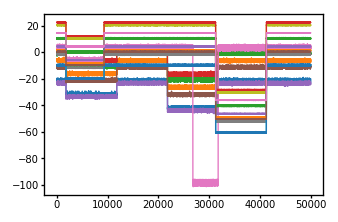

In [6]:
for expt in curr_steps:
    plt.plot(expt[1, :, 0])
plt.show()

Current step recordings have a similar structure, but differ in number of sweeps. Also possibly in spacing of current steps.

Automatically detect the start/end of the test pulse and current steps based on the first recording and then show whether this works for all cells.

In [7]:
change_threshold = 6. # pA threshold at which to detect a step.

tstpts = {'start': [], 'stop': []}
mainpts = {'start': [], 'stop': []}

for expt in curr_steps:
    try:
        falling = np.where(np.diff(expt[1, :, 0]) < -change_threshold)[0]
        tstpts['start'].append(falling[0])
        mainpts['start'].append(falling[1])
        
        rising = np.where(np.diff(expt[1, :, 0]) > change_threshold)[0]
        tstpts['stop'].append(rising[0])
        mainpts['stop'].append(rising[1])
    except ValueError:
        print 'Too many or too few steps detected. Might need to adjust `change_threshold`.'
        raise

del change_threshold

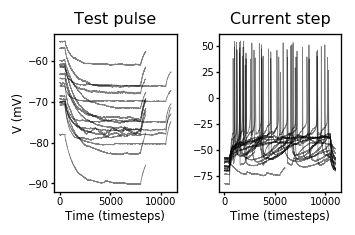

In [8]:
dt = 0.1 # ms. Assumed.

buffer_timesteps = 500

plt.figure()

tst_ax = plt.subplot(121)
tst_ax.set_title('Test pulse')

step_ax = plt.subplot(122)
step_ax.set_title('Current step')

for i, expt in enumerate(curr_steps):
    tst_ax.plot(
        expt[0, (tstpts['start'][i] - buffer_timesteps):(tstpts['stop'][i] + buffer_timesteps), :].mean(axis = 1), 
        'k-', lw = 0.5, alpha = 0.5
    )
    step_ax.plot(
        expt[0, (mainpts['start'][i] - buffer_timesteps):(mainpts['stop'][i] + buffer_timesteps), 8], 
        'k-', lw = 0.5, alpha = 0.5
    )
    
tst_ax.set_xlabel('Time (timesteps)')
tst_ax.set_ylabel('V (mV)')

step_ax.set_xlabel('Time (timesteps)')
step_ax.set_ylabel('')

plt.tight_layout()

plt.show()

In [9]:
qc_mask = []
for i, rec in enumerate(curr_steps):
    if (np.abs(rec[1, :, :] - np.mean(rec[1, :, :])) < 1.).all() :
        qc_mask.append(False)
        rec.plot()
    else:
        qc_mask.append(True)
        
curr_steps = [curr_steps[i] for i in range(len(curr_steps)) if qc_mask[i]]
print '{} of {} cells passed quality control.'.format(len(curr_steps), len(qc_mask))

del qc_mask

17 of 17 cells passed quality control.


## Generate f/I curves

f/I curves are usually rectified linear. However, in some cases non-monotonic f/I curves are observed, usually due to depolarization block.

In [10]:
# Detect spikes in all recordings.
spktimes = [detectSpikes(rec[0, :, :], 0., 3., 0, 0.1) for rec in curr_steps]

In [11]:
spktimes

[[array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([2360.3]),
  array([2317.4, 2508.6]),
  array([2236.3, 2401.8, 2902. , 3164.4]),
  array([2213.7, 2333.9, 2682.5, 2828.2, 3156.7]),
  array([2204.2, 2305.3, 2589.9, 2714.5]),
  array([2199.8, 2286.1, 2419.4, 2518.1, 2895.1]),
  array([2197.7, 2274.8, 2331. , 2522.8, 2610.5, 2814.6]),
  array([2194.6, 2266.6, 2314.4, 2388.7, 2475.6, 2691. , 2771.7])],
 [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([2900.2]),
  array([2512.6]),
  array([2421.6, 2824.3]),
  array([2379.4, 2753.2]),
  array([2350.6, 2627.4, 3000.3]),
  array([2339.3, 2555.6, 2892.4]),
  array([2298.4, 2465.1, 2760.9, 3084.3]),
  array([2295.1, 2451. , 2723.2, 3038.9]),
  array([2282.3, 2407.1, 26

In [12]:
# Extract f/I data.

# Dict to hold output.
fi_data = {'f': [], 'I': [], 'CV': [], 'rheobase': [], 'freq_at_rheobase': [], 'coeffs': [], 'is_monotonic': []}

# Throwaway function to detect whether an f/I curve increases monotonically.
is_monotonic = lambda x_: np.all(np.nan_to_num(np.diff(x_) / x_[:-1]) > -0.25)

for i, (rec, times) in enumerate(zip(curr_steps, spktimes)):
    
    spks_in_window = [
        x[np.logical_and(x >= mainpts['start'][i] * dt, x < mainpts['stop'][i] * dt)] * dt for x in times
    ]
    ISIs_tmp = [np.diff(x) for x in spks_in_window]
    cv_tmp = [x.std() / x.mean() if len(x) > 0 else 0 for x in ISIs_tmp]
    
    f_tmp = np.array(
            [len(x) for x in spks_in_window]
        ) / (1e-3 * dt * (mainpts['stop'][i] - mainpts['start'][i])) # Convert to a rate in Hz.
    I_tmp = rec[1, (mainpts['stop'][i] - 1000):(mainpts['stop'][i] - 10), :].mean(axis = 0) # Scrape input current.
    
    try:
        rheobase_ind = np.where(f_tmp > 1e-4)[0][0]
        freq_at_rheobase_tmp = f_tmp[rheobase_ind]
    except IndexError:
        rec.plot()
        print f_tmp
        print times
        raise
    
    if is_monotonic(f_tmp):
        coeffs_tmp = np.polyfit(I_tmp[rheobase_ind:], f_tmp[rheobase_ind:], 1)
    else:
        coeffs_tmp = [np.nan for i in range(2)]
        
    fi_data['f'].append(f_tmp)
    fi_data['I'].append(I_tmp)
    fi_data['CV'].append(cv_tmp)
    fi_data['rheobase'].append(I_tmp[rheobase_ind])
    fi_data['freq_at_rheobase'].append(freq_at_rheobase_tmp)
    fi_data['coeffs'].append(coeffs_tmp)
    fi_data['is_monotonic'].append(is_monotonic(f_tmp))
    
fi_data['coeffs'] = np.array(fi_data['coeffs'])

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [13]:
fi_df = pd.DataFrame(
    {'rheobase': fi_data['rheobase'], 'freq_at_rheobase': fi_data['freq_at_rheobase'], 'gain': fi_data['coeffs'][:, 0], 'is_monotonic': fi_data['is_monotonic']}
)
fi_df.to_csv(os.path.join('data', 'processed', '5HT', 'current_steps_gain.csv'), index=False)

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


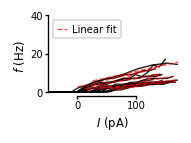

In [14]:
plt.figure(figsize=(1.5, 1))

curves = plt.subplot(111)

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            curves.plot(
                x[y>1e-3],
                np.polyval(coeffs, x[y>1e-3]),
                'r--',
                alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        curves.plot(x, y, '-', color = 'gray', alpha = 0.4)

curves.set_xlim(-50, 170)
curves.set_ylim(-2, 40)

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only.svg'))
    

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


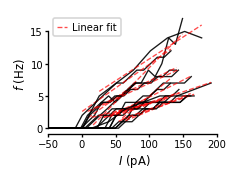

In [15]:
plt.figure(figsize=(2, 1.5))

curves = plt.subplot(111)

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            curves.plot(
                x[y>1e-3],
                np.polyval(coeffs, x[y>1e-3]),
                'r--',
                alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        curves.plot(x, y, '-', color = 'gray', alpha = 0.4)

curves.set_xlim(-50, curves.get_xlim()[1])

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only_unscaled.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_fi_curve_only_unscaled.svg'))
    

In [16]:
print(
    'Rheobase: {:.3f} +/- {:.3f} pA'.format(
        np.nanmean(fi_data['rheobase']), stats.sem(fi_data['rheobase'], nan_policy='omit')
    )
)
print(
    'Gain: {:.4f} +/- {:.4f} Hz/pA'.format(
        np.nanmean(fi_data['coeffs'][:, 0]), stats.sem(fi_data['coeffs'][:, 0], nan_policy='omit')
    )
)

Rheobase: 33.794 +/- 5.098 pA
Gain: 0.0522 +/- 0.0054 Hz/pA
